In [415]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [416]:
import pandas as pd
import numpy as np
import re
import torch
from tqdm.auto import tqdm
import random
import os


import matplotlib.pyplot as plt
import seaborn as sns


DATA_PATH = '/content/drive/MyDrive/데이콘 캐글 컴페티션/2023신약개발/data/'
SEED = 42


def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [417]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [418]:
train.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [419]:
train.columns

Index(['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea'],
      dtype='object')

# 전체 - target 데이터

- LogD 작을수록, Log P 작을 수록, 수소 donors 많을 수록, 극성 영역 넓을수록, 수소 수용체 많을 수록, 대사안정성 높음?

In [420]:
from sklearn.preprocessing import MinMaxScaler


# MinMax 스케일러 생성
scaler = MinMaxScaler()

df = train.copy()

# 스케일링을 수행할 열 선택 (예: 'SMILES_H_count'와 'MLM' 칼럼)
columns_to_scale = ['MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea'] #,'SMILES_length','SMILES_H_count'

# 선택한 열에 대해 MinMax 스케일링 수행
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# 스케일링된 데이터를 train_minmax 변수에 저장
train_minmax = df.copy()


In [421]:
train_minmax

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,0.197464,0.374475,0.554964,0.192138,0.333333,0.2,0.210526,0.579660,0.389270
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,0.222214,0.373810,0.473175,0.108751,0.133333,0.1,0.052632,0.502622,0.239538
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,0.042408,0.597712,0.429954,0.105343,0.333333,0.0,0.078947,0.461021,0.201951
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,0.043350,0.014778,0.668417,0.271376,0.400000,0.0,0.131579,0.594968,0.304785
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,0.708093,0.738828,0.485631,0.080898,0.200000,0.0,0.026316,0.514316,0.133668
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,0.011813,0.022751,0.566219,0.188519,0.200000,0.1,0.131579,0.590291,0.209762
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,0.269967,0.351939,0.453891,0.157539,0.266667,0.1,0.078947,0.479376,0.252839
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,0.426283,0.013226,0.456067,0.075016,0.200000,0.1,0.157895,0.499220,0.228180
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.000228,0.020468,0.384633,0.094688,0.333333,0.1,0.131579,0.418781,0.301068


In [422]:
train.corr()['MLM'].sort_values() #LogD, AlogP, Num_H Doners, Polarsurface, Num H Acceptors : 약한 상관관계 가능성

<ipython-input-422-c72b4406481f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()['MLM'].sort_values() #LogD, AlogP, Num_H Doners, Polarsurface, Num H Acceptors : 약한 상관관계 가능성


LogD                         -0.350146
AlogP                        -0.330083
Num_RotatableBonds           -0.092563
Molecular_Weight             -0.081239
Num_H_Acceptors               0.164510
Molecular_PolarSurfaceArea    0.184850
Num_H_Donors                  0.210836
HLM                           0.706725
MLM                           1.000000
Name: MLM, dtype: float64

In [423]:
np.abs(train.corr()['MLM']).sort_values(ascending=False)

<ipython-input-423-7e881c0ce5f2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  np.abs(train.corr()['MLM']).sort_values(ascending=False)


MLM                           1.000000
HLM                           0.706725
LogD                          0.350146
AlogP                         0.330083
Num_H_Donors                  0.210836
Molecular_PolarSurfaceArea    0.184850
Num_H_Acceptors               0.164510
Num_RotatableBonds            0.092563
Molecular_Weight              0.081239
Name: MLM, dtype: float64

In [424]:
train.corr()['HLM']

<ipython-input-424-e6ff0b035543>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()['HLM']


MLM                           0.706725
HLM                           1.000000
AlogP                        -0.346022
Molecular_Weight             -0.175117
Num_H_Acceptors               0.092313
Num_H_Donors                  0.176549
Num_RotatableBonds           -0.132263
LogD                         -0.357456
Molecular_PolarSurfaceArea    0.094323
Name: HLM, dtype: float64

In [425]:
np.abs(train.corr()['HLM']).sort_values(ascending=False)

<ipython-input-425-3e0e967aae25>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  np.abs(train.corr()['HLM']).sort_values(ascending=False)


HLM                           1.000000
MLM                           0.706725
LogD                          0.357456
AlogP                         0.346022
Num_H_Donors                  0.176549
Molecular_Weight              0.175117
Num_RotatableBonds            0.132263
Molecular_PolarSurfaceArea    0.094323
Num_H_Acceptors               0.092313
Name: HLM, dtype: float64

Text(0, 0.5, 'HLM')

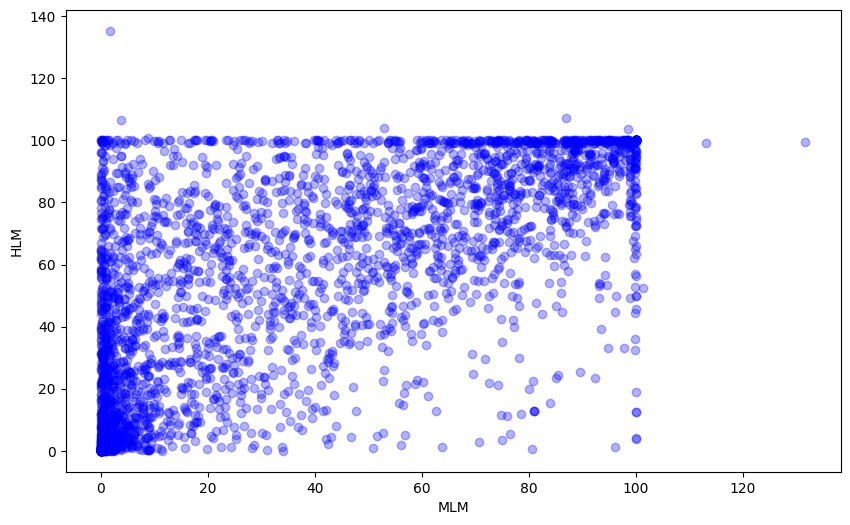

In [426]:
df = train.copy() #스케일링된 결과값을

plt.figure(figsize=(10, 6))
# plt.plot(df.index, df['MLM'], marker='o', linestyle='-', color='g', label='MLM')
# plt.plot(df.index, df['SMILES_H_count'], marker='o', linestyle='-', color='b', label='SMILES_H_count')

plt.scatter(df['MLM'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('MLM')
plt.ylabel('HLM')


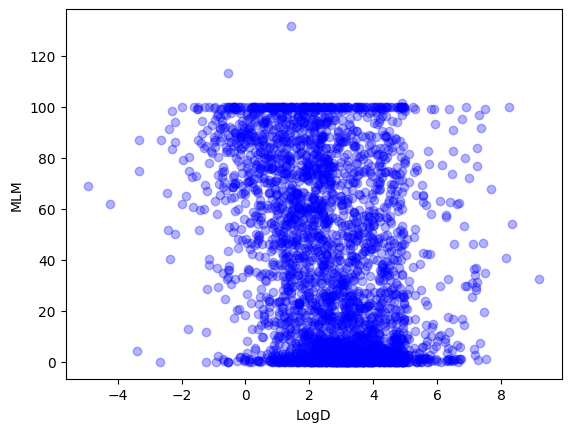

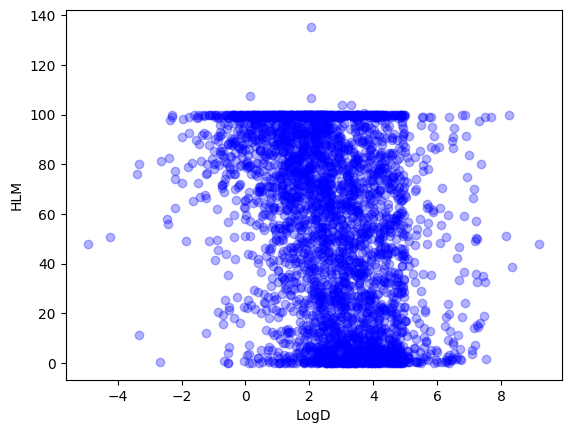

In [427]:

plt.scatter(df['LogD'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('LogD')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['LogD'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('LogD')
plt.ylabel('HLM')
plt.show()

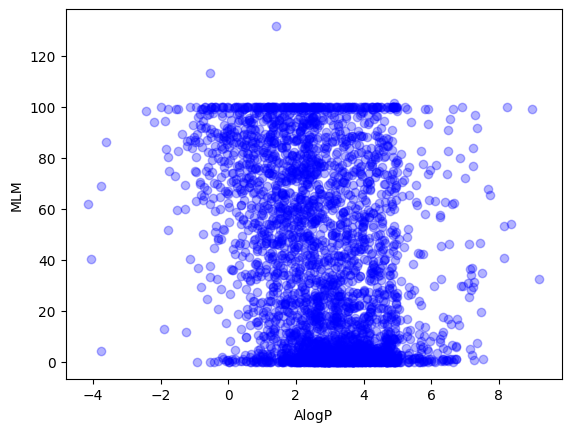

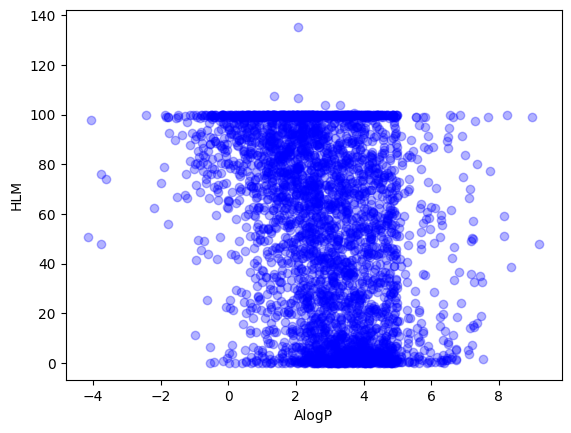

In [428]:


plt.scatter(df['AlogP'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('AlogP')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['AlogP'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('AlogP')
plt.ylabel('HLM')
plt.show()


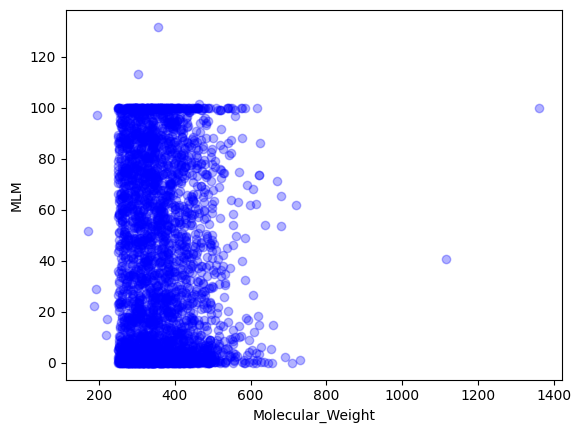

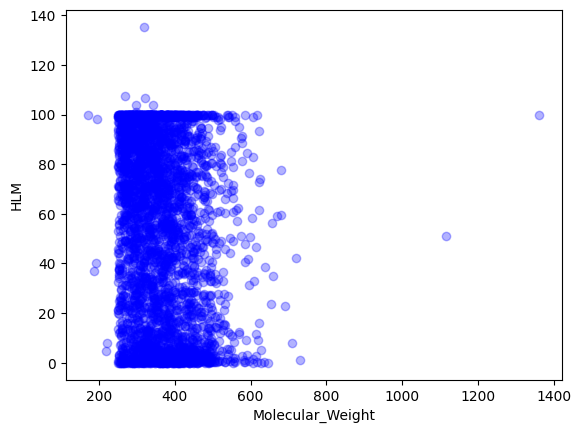

In [429]:

plt.scatter(df['Molecular_Weight'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Molecular_Weight')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['Molecular_Weight'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Molecular_Weight')
plt.ylabel('HLM')
plt.show()

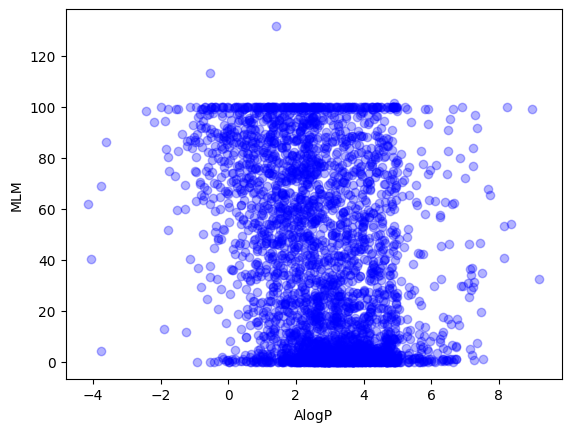

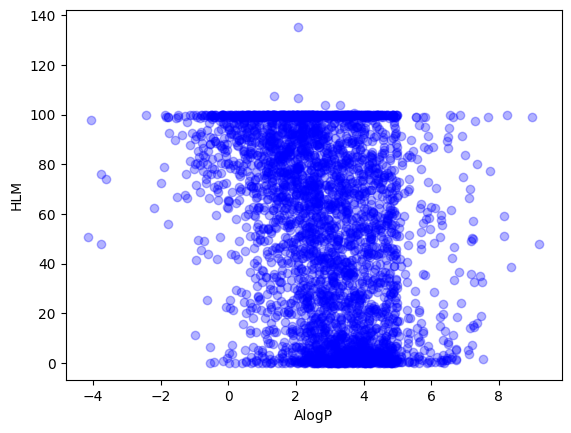

In [430]:
plt.scatter(df['AlogP'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('AlogP')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['AlogP'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('AlogP')
plt.ylabel('HLM')
plt.show()


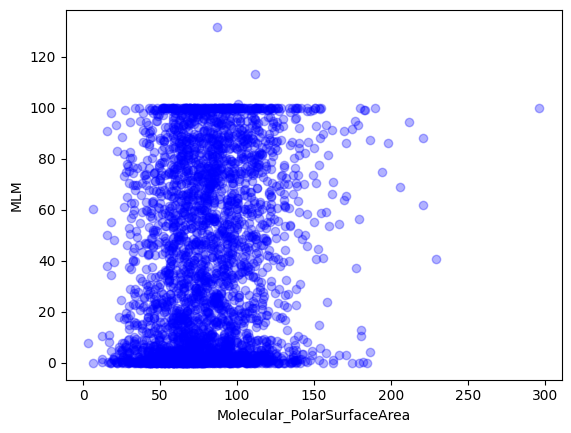

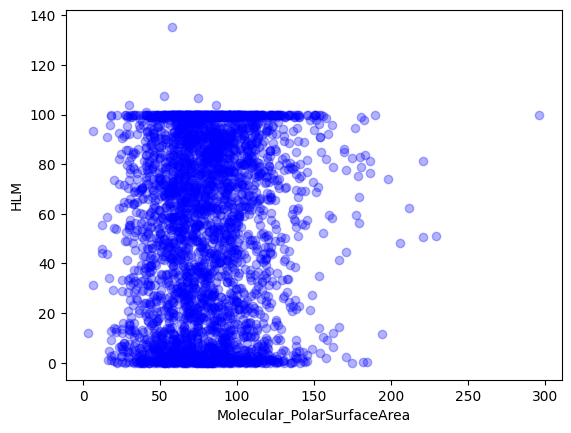

In [431]:
plt.scatter(df['Molecular_PolarSurfaceArea'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Molecular_PolarSurfaceArea')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['Molecular_PolarSurfaceArea'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Molecular_PolarSurfaceArea')
plt.ylabel('HLM')
plt.show()

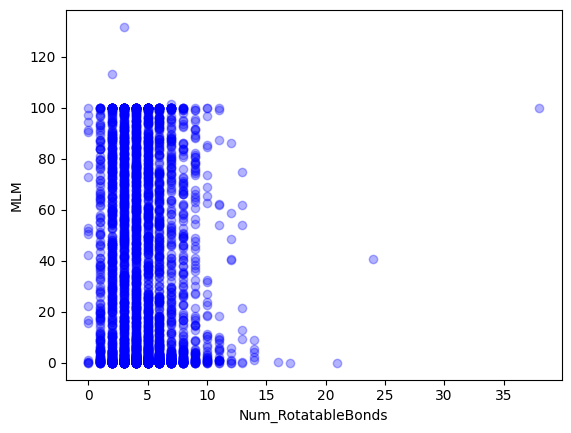

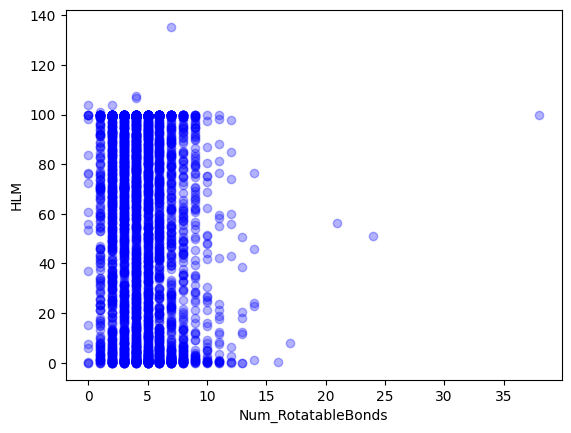

In [432]:
plt.scatter(df['Num_RotatableBonds'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Num_RotatableBonds')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['Num_RotatableBonds'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Num_RotatableBonds')
plt.ylabel('HLM')
plt.show()

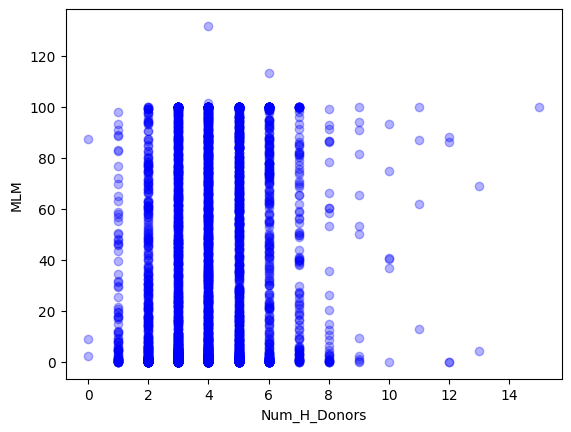

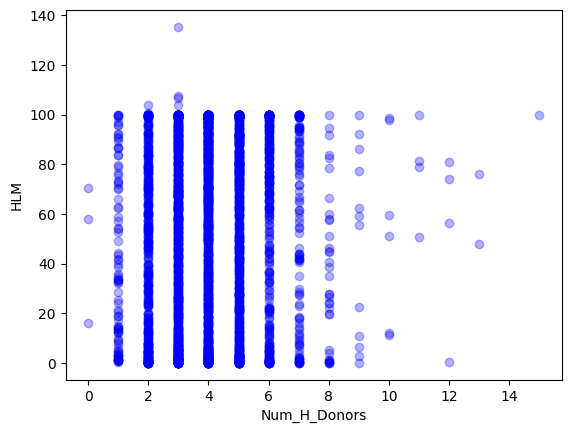

In [433]:
plt.scatter(df['Num_H_Acceptors'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Num_H_Donors')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['Num_H_Acceptors'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Num_H_Donors')
plt.ylabel('HLM')
plt.show()


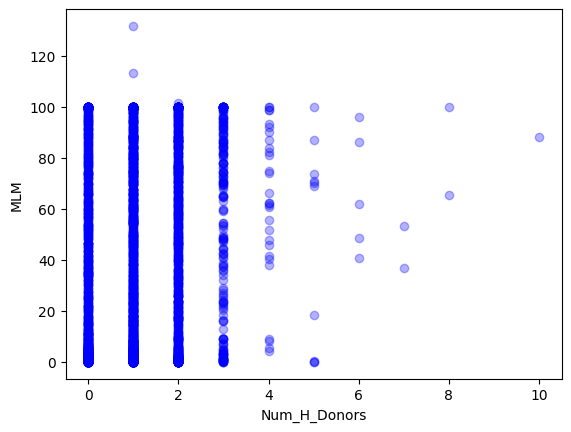

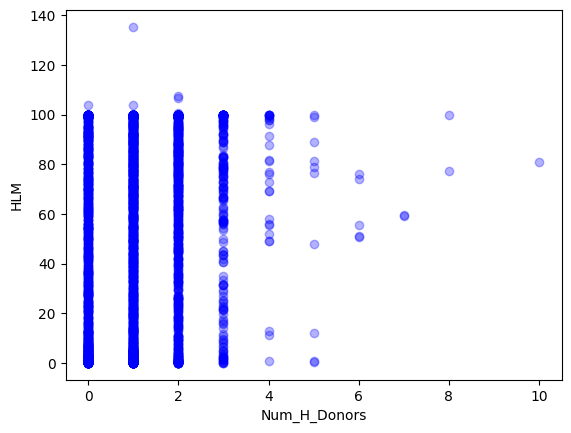

In [434]:
plt.scatter(df['Num_H_Donors'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Num_H_Donors')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['Num_H_Donors'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Num_H_Donors')
plt.ylabel('HLM')
plt.show()


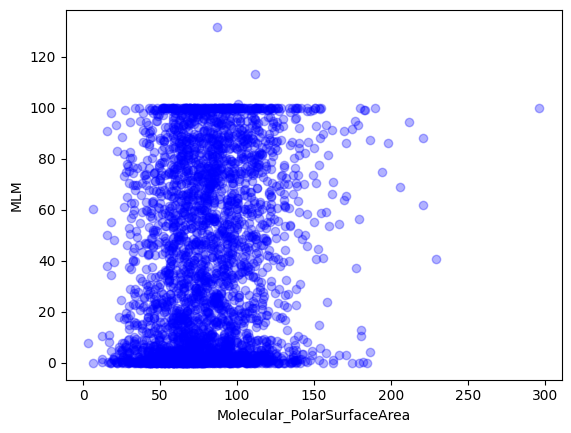

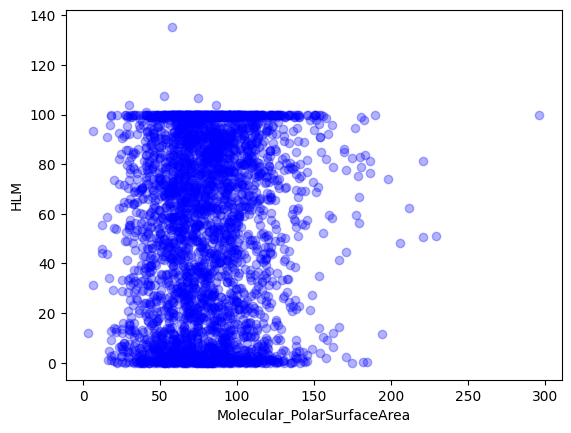

In [435]:


plt.scatter(df['Molecular_PolarSurfaceArea'], df['MLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Molecular_PolarSurfaceArea')
plt.ylabel('MLM')
plt.show()

plt.scatter(df['Molecular_PolarSurfaceArea'], df['HLM'], c='b', marker='o',alpha = 0.3 )
plt.xlabel('Molecular_PolarSurfaceArea')
plt.ylabel('HLM')
plt.show()

# 결측치/ 이상치 확인

## 결측치 : AlogP

In [436]:
train.isna().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         2
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [437]:
# AlogP (2796, 3387)
mask = train['AlogP'].isna()
train[mask]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2796,TRAIN_2796,[H][C@]1(CC[C@@]2([H])[C@@H](C)C=CC3=C[C@H](C)...,0.549,0.2,NaN,418.566,5,1,7,4.634,72.83
3387,TRAIN_3387,COc1cc2c(cc1OC)/C(=N\c1ccccc1)N(Cc1ccccc1F)CC2,0.240,3.2,NaN,390.450,3,0,5,4.911,34.06


In [438]:
test.isna().sum()

id                            0
SMILES                        0
AlogP                         1
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [439]:
# AlogP
mask = test['AlogP'].isna()
test[mask]

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
10,TEST_010,[H]C1(C(O)c2ccc3c(c2)OCO3)C(=O)Oc2cc(OC)ccc2C1...,NaN,404.412,6,1,4,3.942,74.22


In [440]:
# 결측치 채우기
train["AlogP"] = np.where(pd.isna(train["AlogP"]), train["LogD"], train["AlogP"])
test["AlogP"] = np.where(pd.isna(test["AlogP"]), test["LogD"], test["AlogP"])

## 이상치

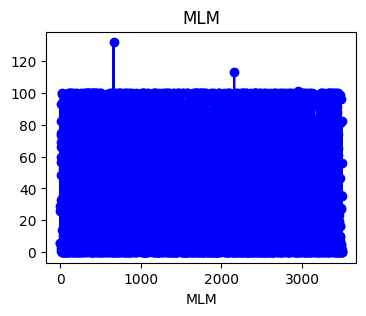

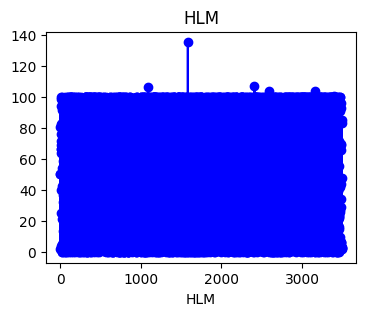

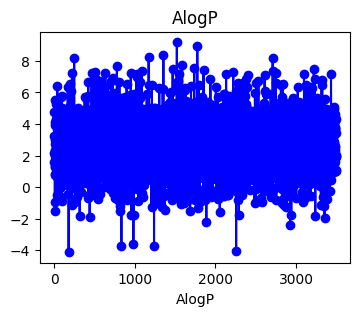

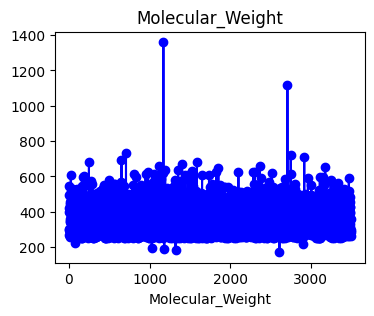

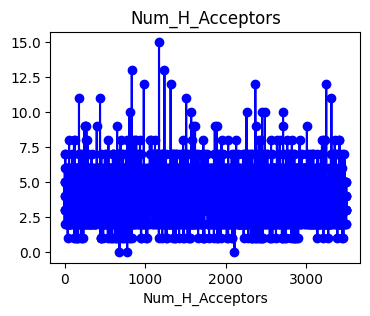

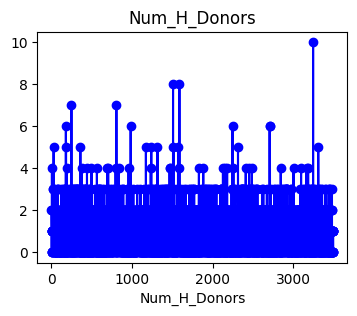

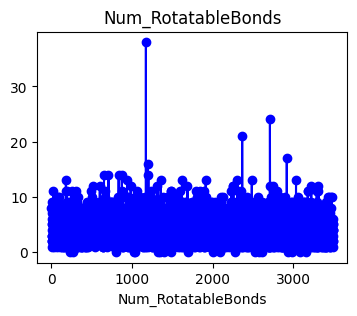

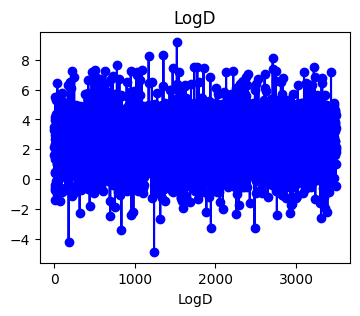

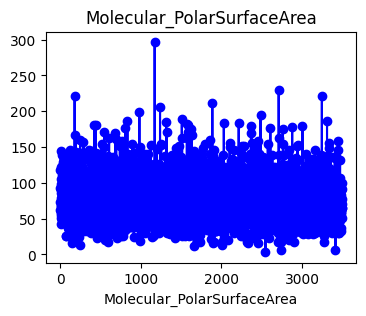

In [441]:
def plot_outliers_all_columns(df):
    for column_name in df.columns:
        plt.figure(figsize=(4,3))
        plt.plot(df.index, df[column_name],marker='o', color='b')  # 데이터 인덱스와 'logD' 값을 사용하여 선 그래프를 그립니다., marker='o', linestyle='-', color='b'
        plt.title(f'{column_name}')
        plt.xlabel(column_name)
        plt.show()


plot_outliers_all_columns(train[['MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea']])

# MLM, HLM : 100이상 / AlogP : ~3 이하, 8-9 이상 / Mweight : 800 이상, 200 이하
# numHact : 12.5이상, 0.5 이하 / numHdn : 8이상 / RB : 20 이상 / LogD : 9이상, -4 이하 / Mpsa : 250 이상 ??

In [442]:
def plot_outliers_all_columns(df):
    for column_name in df.columns:
        plt.figure(figsize=(4,3))
        sns.boxplot(x=df[column_name], color='b')
        plt.title(f'{column_name}')
        plt.xlabel(column_name)
        plt.show()

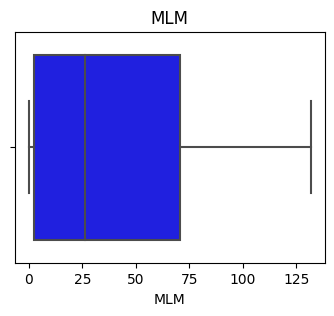

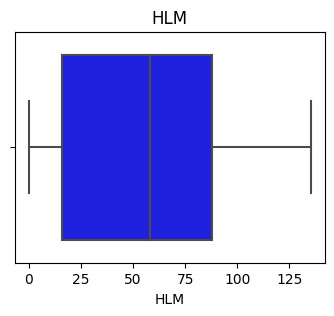

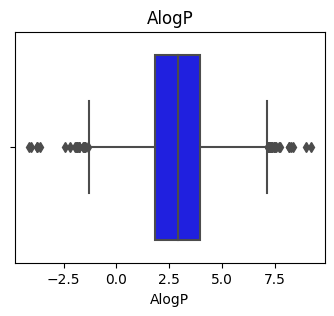

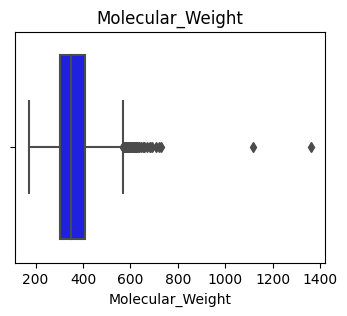

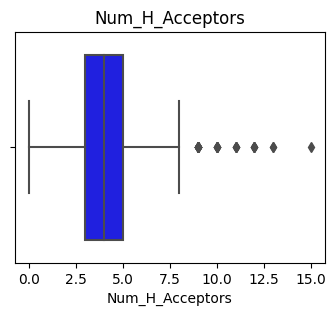

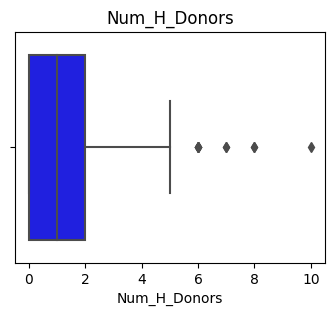

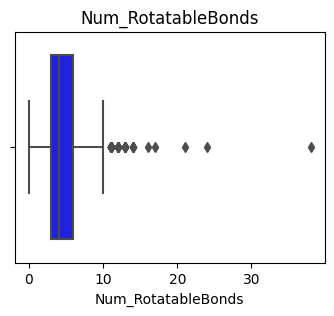

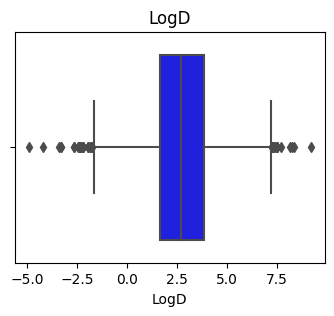

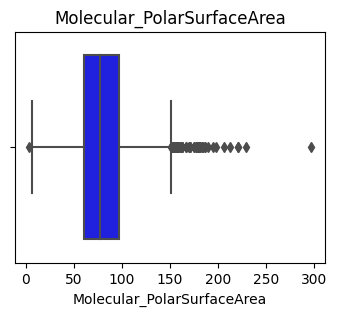

In [443]:
plot_outliers_all_columns(train[['MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea']])

# 박스 바깥 : q1 - q3의 값
#MLM, HLM이라는 실험 결과 이외에는 이상치들이 많음

- isolation forest 이용

In [444]:
train.iloc[:,2:]

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...,...,...
3493,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74
3494,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37
3495,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14
3496,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% 0.0 / 99% 99.99


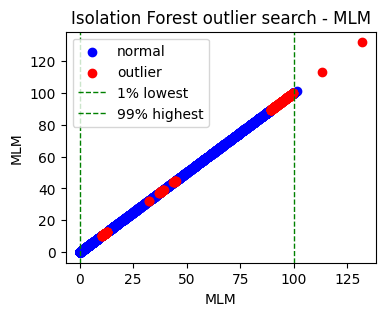

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% 0.0 / 99% 99.99


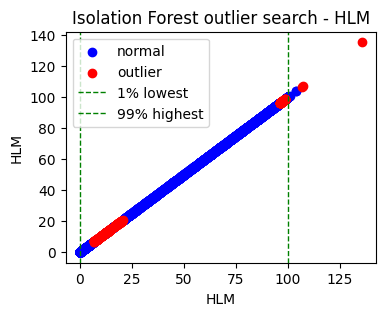

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% -1.5075100000000001 / 99% 7.243574999999999


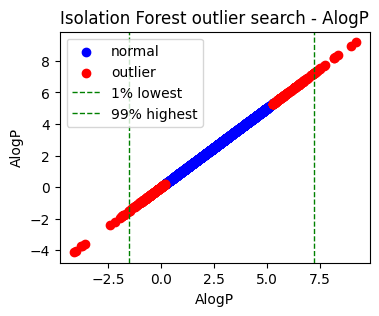

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% 250.314425 / 99% 624.6843149999997


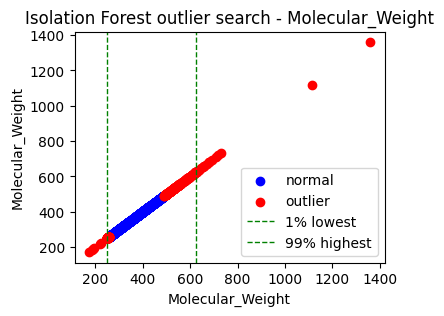

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% 1.0 / 99% 9.0


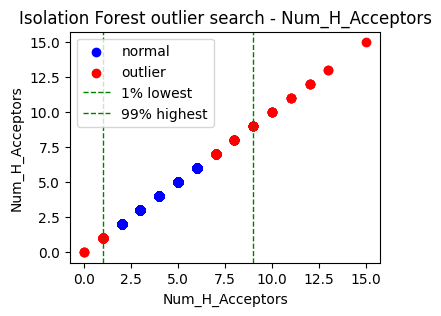

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% 0.0 / 99% 5.0


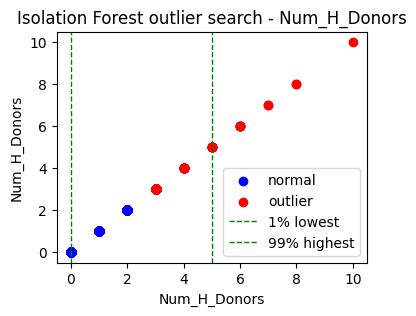

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% 0.0 / 99% 12.514999999999873


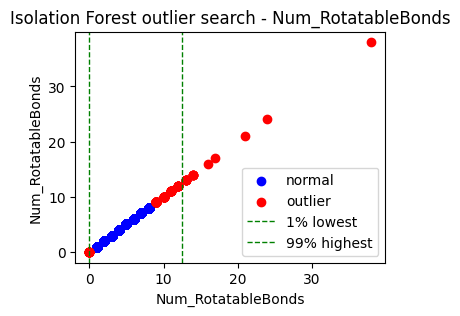

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% -1.95842 / 99% 7.215419999999996


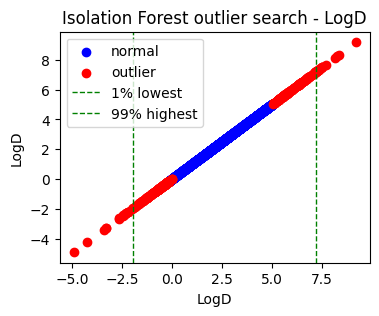

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


1% 17.82 / 99% 179.79349999999988


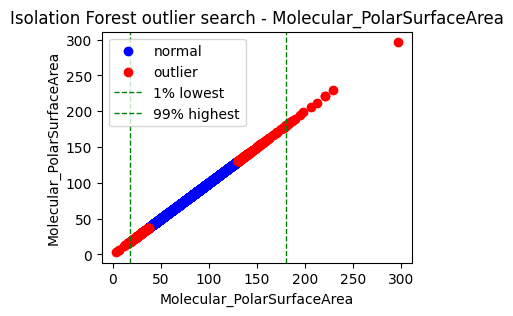

In [445]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pandas as pd

# Isolation Forest 모델 생성
clf = IsolationForest(contamination=0.1, random_state=42)  # contamination은 이상치 비율을 나타냅니다.
data = train.iloc[:,2:]

for column in data.columns:
    X = data[[column]]
    clf.fit(X)

    # 이상치 예측
    y_pred = clf.predict(X)

    # 결과 시각화
    plt.figure(figsize=(4, 3))

    # 정상 데이터 플롯
    plt.scatter(X[y_pred == 1], X[y_pred == 1], c='blue', label='normal')

    # 이상치 데이터 플롯
    plt.scatter(X[y_pred == -1], X[y_pred == -1], c='red', label='outlier')

    q1 = np.percentile(X, 0.5)  # 0.5% 최하위 분위수
    q99 = np.percentile(X, 99.5)  # 99.5% 최상위 분위수

    print('0.5%',q1, '/','99.5%',q99)
    plt.axvline(q1, color='green', linestyle='--', linewidth=1, label='1% lowest')
    plt.axvline(q99, color='green', linestyle='--', linewidth=1, label='99% highest')


    plt.title(f"Isolation Forest outlier search - {column}")
    plt.xlabel(column)
    plt.ylabel(column)
    plt.legend()
    plt.show()

In [446]:
outlier_indices = np.where(y_pred == -1)[0]
len(outlier_indices)

349

In [447]:
train.iloc[:,2:]

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...,...,...
3493,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74
3494,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37
3495,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14
3496,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51


In [448]:

# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# def calculate_z_scores(data):
#     mean = np.mean(data)
#     std_dev = np.std(data)
#     z_scores = (data - mean) / std_dev
#     return z_scores

# def calculate_iqr(data):
#     q1 = np.percentile(data, 25)
#     q3 = np.percentile(data, 75)
#     iqr = q3 - q1
#     return iqr

# def create_qq_plot(data):
#     stats.probplot(data, dist="norm", plot=plt)
#     plt.title("QQ Plot")
#     plt.show()


### -> 이상치 제거 (총 18개)

In [449]:
# 1. 극단치만 판단해서 18개 제거
outliers = train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0) | (train['AlogP'] < -3) | (train['Molecular_Weight'] > 800)
     | (train['Num_H_Acceptors'] > 14) | (train['Num_H_Donors'] > 9) | (train['Num_RotatableBonds'] > 20)
     | (train['LogD'] < -4) | (train['Molecular_PolarSurfaceArea'] > 250)]


# 2. 상위 0.5% 이상치만 - 91개
# outliers = train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0) | (train['AlogP'] > 7 ) | (train['Molecular_Weight'] > 625)
#      | (train['Num_H_Acceptors'] > 8) | (train['Num_H_Donors'] > 4) | (train['Num_RotatableBonds'] > 12)
#      | (train['LogD'] > 7.5 ) | (train['Molecular_PolarSurfaceArea'] > 180)]


# 3. 상위 0.5% 이상치, num관련된 것들 제외 - 67개
# outliers = train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0) | (train['AlogP'] > 7 ) | (train['Molecular_Weight'] > 625)
#         | (train['LogD'] > 7.5 ) | (train['Molecular_PolarSurfaceArea'] > 180)]

# 4. 상위 0.5%, 하위 99.5% 이상치 - 198개
# outliers = train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0) | ( -1.5 > train['AlogP']) | (train['AlogP'] > 6.5  ) | ( 250 > train['Molecular_Weight']) |  (train['Molecular_Weight'] > 600)
#      |   (train['Num_H_Acceptors'] > 8) | (train['Num_H_Acceptors'] < 1 ) | (train['Num_H_Donors'] > 4  )  | (train['Num_RotatableBonds'] > 11 )
#      | (train['LogD'] > 6.5)  | (-1.5 > train['LogD']  ) | (train['Molecular_PolarSurfaceArea'] > 152) |(18 > train['Molecular_PolarSurfaceArea'] )]

# 4.
# outliers = train[(train['MLM'] >= 100.0) | (train['HLM'] >= 100.0)]


In [450]:
outliers.index

Int64Index([ 179,  662,  834,  983, 1092, 1172, 1239, 1584, 2159, 2258, 2367,
            2410, 2586, 2711, 2948, 3157, 3247, 3403],
           dtype='int64')

In [451]:
len(outliers.index)

18

In [452]:
train = train.drop(index=outliers.index, axis=0)


In [453]:
train.shape # 3498 -> 3480

(3480, 11)

## 중복치
- 2쌍씩 중복되는 케이스 총 27쌍 (54개의 데이터) -> 이상치 제거후에 총 26쌍 됨
- MLM, HLM 데이터만 차이있고 나머지 데이터 값 동일함

- > 둘중 하나 실험 오류로 보고 선택하기? 유사값인 경우 평균내기?

In [454]:
duplicates = train[train.duplicated(subset=['SMILES'], keep=False)]

duplicates.sort_values(by='SMILES')


,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [455]:
duplicates.shape # 이상치 제거로 27 -> 26쌍

(52, 11)

In [456]:
processed_duplicate = duplicates.groupby('SMILES')['MLM','HLM'].mean().reset_index()
processed_duplicate

<ipython-input-456-c0f91ccc9bed>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  processed_duplicate = duplicates.groupby('SMILES')['MLM','HLM'].mean().reset_index()


,SMILES,MLM,HLM
0,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.9225,28.0615
1,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,62.2175,77.9110
2,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,68.6310,64.6690
3,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,32.1435,85.6850
4,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,3.6870,43.3385
5,CC(C)NC(=O)c1c(Cl)nn(C)c1NC(=O)c1cc(Br)nn1-c1n...,62.1085,68.1015
6,CC1CC(=O)N(c2ccc(-c3cccc(C#N)c3)cc2)N=C1c1ccc(...,43.1700,31.1300
7,CCCCC/N=c1\n(C)c(=O)nc2sccn12,2.3395,36.8145
8,CCOC(=O)CC1(NC(=O)N2Cc3c(sc4c3CCCC4)-n3cccc3C2...,3.4420,3.6015
9,CCc1nc2cc(Br)c(C(=O)OC)nc2n1CC(=O)c1ccccc1,73.5450,1.1345


In [457]:
tmp = pd.merge(processed_duplicate,duplicates,how='left',on='SMILES')
tmp

,SMILES,MLM_x,HLM_x,id,MLM_y,HLM_y,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.9225,28.0615,TRAIN_0451,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
1,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.9225,28.0615,TRAIN_2276,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
2,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,62.2175,77.9110,TRAIN_0543,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
3,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,62.2175,77.9110,TRAIN_2891,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
4,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,68.6310,64.6690,TRAIN_0366,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
5,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,68.6310,64.6690,TRAIN_0837,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
6,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,32.1435,85.6850,TRAIN_1085,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
7,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,32.1435,85.6850,TRAIN_2848,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
8,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,3.6870,43.3385,TRAIN_1666,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85
9,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,3.6870,43.3385,TRAIN_2096,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85


### -> 중복치 제거 (총 26개)

In [458]:
tmp = tmp.iloc[0::2]  # 첫 번째 행부터 시작하여 2씩 증가하여 행 선택
tmp.drop(['MLM_y','HLM_y'],axis =1,inplace=True)

<ipython-input-458-d20f759e9146>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.drop(['MLM_y','HLM_y'],axis =1,inplace=True)


In [459]:
tmp.columns = ['SMILES', 'MLM', 'HLM','id',  'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea']

In [460]:
processed_duplicate = tmp[['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea']]

In [461]:
train = train.drop_duplicates(subset=['SMILES'], keep=False) #기존 train에서 중복치들을 우선 모두 제거
train.shape

(3428, 11)

In [462]:
processed_duplicate.shape

(26, 11)

In [463]:
train = pd.concat([train, processed_duplicate], axis=0, ignore_index=True)
train.shape

(3454, 11)

# 모델학습, 검증, 제출

In [464]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [465]:
from sklearn.metrics import mean_squared_error

def rmse(y_valid, pred):
    mse = mean_squared_error(y_valid, pred)
    return np.sqrt(mse)

In [466]:
from sklearn.metrics import make_scorer

rmse_score = make_scorer(rmse, greater_is_better=False)

In [467]:
# 결측치 채우기
train["AlogP"] = np.where(pd.isna(train["AlogP"]), train["LogD"], train["AlogP"])
test["AlogP"] = np.where(pd.isna(test["AlogP"]), test["LogD"], test["AlogP"])

In [468]:
train_prop = train.iloc[:, 4:]
test_prop = test.iloc[:, 2:]

target_1 = train['MLM']
target_2 = train['HLM']

In [469]:
train_prop

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,3.259,400.495,5,2,8,3.259,117.37
1,2.169,301.407,2,1,2,2.172,73.47
2,1.593,297.358,5,0,3,1.585,62.45
3,4.771,494.652,6,0,5,3.475,92.60
4,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...
3449,4.609,340.381,4,1,2,4.736,71.75
3450,4.282,553.480,5,0,7,4.009,65.98
3451,4.304,459.520,6,1,4,4.304,113.53
3452,-1.133,385.417,7,0,4,-1.133,108.65


In [470]:
test_prop

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,2.641,361.505,4,2,7,2.635,92.76
1,0.585,370.399,5,0,3,0.585,68.31
2,4.276,347.414,4,4,5,4.290,92.86
3,1.795,345.358,5,0,2,1.795,81.21
4,1.219,353.418,4,0,2,0.169,61.15
...,...,...,...,...,...,...,...
478,4.207,306.443,2,1,7,4.207,55.13
479,-0.608,335.398,5,0,1,-1.736,70.16
480,1.792,349.383,3,1,3,1.792,69.72
481,0.790,341.132,3,2,2,0.423,69.64


#### randomforest

In [471]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

scores = []
for tri, val in cv.split(train_prop, target_1):
    # 학습데이터
    x_train = train_prop.iloc[tri]
    y_train_1 = target_1.iloc[tri]
    y_train_2 = target_2.iloc[tri]

    # 검증데이터
    x_valid = train_prop.iloc[val]
    y_valid_1 = target_1.iloc[val]
    y_valid_2 = target_2.iloc[val]

    # MLM
    model = RandomForestRegressor(random_state=SEED)
    model.fit(x_train, y_train_1)
    pred = model.predict(x_valid)
    score_1 = rmse(y_valid_1, pred)

    #HLM
    model = RandomForestRegressor(random_state=SEED)
    model.fit(x_train, y_train_2)
    pred = model.predict(x_valid)
    score_2 = rmse(y_valid_2, pred)

    score = 0.5*score_1 + 0.5*score_2
    scores.append(score)

print(scores)
np.mean(scores)

[32.40695022678321, 35.028172719054936, 32.423388984432805, 32.397726771803875, 32.75328566235895]


33.001904872886755

In [472]:
model.fit(train_prop, target_1)
rf_pred_1 = model.predict(test_prop)

model.fit(train_prop, target_2)
rf_pred_2 = model.predict(test_prop)

#### XGBRegressor

In [473]:
scores = []
for tri, val in cv.split(train_prop, target_1):
    # 학습데이터
    x_train = train_prop.iloc[tri]
    y_train_1 = target_1.iloc[tri]
    y_train_2 = target_2.iloc[tri]

    # 검증데이터
    x_valid = train_prop.iloc[val]
    y_valid_1 = target_1.iloc[val]
    y_valid_2 = target_2.iloc[val]

    # MLM
    model = XGBRegressor(random_state=SEED)
    model.fit(x_train, y_train_1, eval_set=[(x_valid, y_valid_1)], eval_metric='rmse')
    pred = model.predict(x_valid)
    score_1 = rmse(y_valid_1, pred)

    # HLM
    model = XGBRegressor(random_state=SEED)
    model.fit(x_train, y_train_2, eval_set=[(x_valid, y_valid_2)], eval_metric='rmse')
    pred = model.predict(x_valid)
    score_2 = rmse(y_valid_2, pred)

    score = 0.5*score_1 + 0.5*score_2
    scores.append(score)

print(scores)
np.mean(scores)

[0]	validation_0-rmse:41.19260
[1]	validation_0-rmse:36.40514
[2]	validation_0-rmse:33.76966
[3]	validation_0-rmse:32.17422
[4]	validation_0-rmse:31.47671
[5]	validation_0-rmse:31.08319
[6]	validation_0-rmse:30.80894
[7]	validation_0-rmse:30.74215
[8]	validation_0-rmse:30.71872
[9]	validation_0-rmse:30.81083
[10]	validation_0-rmse:30.90747
[11]	validation_0-rmse:31.08348
[12]	validation_0-rmse:31.11224
[13]	validation_0-rmse:31.20164
[14]	validation_0-rmse:31.33796
[15]	validation_0-rmse:31.34027
[16]	validation_0-rmse:31.41133
[17]	validation_0-rmse:31.41868
[18]	validation_0-rmse:31.36557
[19]	validation_0-rmse:31.40667
[20]	validation_0-rmse:31.42460


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:31.48182
[22]	validation_0-rmse:31.51174
[23]	validation_0-rmse:31.66550
[24]	validation_0-rmse:31.73148
[25]	validation_0-rmse:31.74067
[26]	validation_0-rmse:31.72984
[27]	validation_0-rmse:31.83109
[28]	validation_0-rmse:31.87766
[29]	validation_0-rmse:31.95051
[30]	validation_0-rmse:31.93629
[31]	validation_0-rmse:31.97283
[32]	validation_0-rmse:32.03315
[33]	validation_0-rmse:32.06613
[34]	validation_0-rmse:32.05294
[35]	validation_0-rmse:32.02346
[36]	validation_0-rmse:32.03599
[37]	validation_0-rmse:32.04104
[38]	validation_0-rmse:32.09970
[39]	validation_0-rmse:32.17541
[40]	validation_0-rmse:32.21646
[41]	validation_0-rmse:32.21480
[42]	validation_0-rmse:32.19126
[43]	validation_0-rmse:32.28054
[44]	validation_0-rmse:32.30367
[45]	validation_0-rmse:32.35951
[46]	validation_0-rmse:32.38266
[47]	validation_0-rmse:32.38809
[48]	validation_0-rmse:32.39502
[49]	validation_0-rmse:32.42537
[50]	validation_0-rmse:32.41337
[51]	validation_0-rmse:32.43730
[52]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:33.25639
[19]	validation_0-rmse:33.36723
[20]	validation_0-rmse:33.36239
[21]	validation_0-rmse:33.41234
[22]	validation_0-rmse:33.40957
[23]	validation_0-rmse:33.52916
[24]	validation_0-rmse:33.53408
[25]	validation_0-rmse:33.66016
[26]	validation_0-rmse:33.67610
[27]	validation_0-rmse:33.70926
[28]	validation_0-rmse:33.80489
[29]	validation_0-rmse:33.81291
[30]	validation_0-rmse:33.88067
[31]	validation_0-rmse:33.89498
[32]	validation_0-rmse:33.93829
[33]	validation_0-rmse:33.96251
[34]	validation_0-rmse:33.97158
[35]	validation_0-rmse:33.94974
[36]	validation_0-rmse:33.96972
[37]	validation_0-rmse:33.98089
[38]	validation_0-rmse:33.97439
[39]	validation_0-rmse:33.92356
[40]	validation_0-rmse:33.94371
[41]	validation_0-rmse:34.01023
[42]	validation_0-rmse:33.98369
[43]	validation_0-rmse:34.06868
[44]	validation_0-rmse:34.08759
[45]	validation_0-rmse:34.08657
[46]	validation_0-rmse:34.07763
[47]	validation_0-rmse:34.04091
[48]	validation_0-rmse:34.09707
[49]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:35.27446
[20]	validation_0-rmse:35.29960
[21]	validation_0-rmse:35.30693
[22]	validation_0-rmse:35.33069
[23]	validation_0-rmse:35.37094
[24]	validation_0-rmse:35.40385
[25]	validation_0-rmse:35.43658
[26]	validation_0-rmse:35.47361
[27]	validation_0-rmse:35.56126
[28]	validation_0-rmse:35.56633
[29]	validation_0-rmse:35.61127
[30]	validation_0-rmse:35.54779
[31]	validation_0-rmse:35.56619
[32]	validation_0-rmse:35.66247
[33]	validation_0-rmse:35.67612
[34]	validation_0-rmse:35.68067
[35]	validation_0-rmse:35.75753
[36]	validation_0-rmse:35.73464
[37]	validation_0-rmse:35.77334
[38]	validation_0-rmse:35.80834
[39]	validation_0-rmse:35.83406
[40]	validation_0-rmse:35.91024
[41]	validation_0-rmse:35.91846
[42]	validation_0-rmse:35.85849
[43]	validation_0-rmse:35.87540
[44]	validation_0-rmse:35.86472
[45]	validation_0-rmse:35.90518
[46]	validation_0-rmse:35.93388
[47]	validation_0-rmse:35.96024
[48]	validation_0-rmse:35.97265
[49]	validation_0-rmse:35.99363
[50]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:35.10169
[20]	validation_0-rmse:35.16171
[21]	validation_0-rmse:35.22382
[22]	validation_0-rmse:35.31168
[23]	validation_0-rmse:35.36093
[24]	validation_0-rmse:35.47429
[25]	validation_0-rmse:35.47240
[26]	validation_0-rmse:35.42566
[27]	validation_0-rmse:35.41159
[28]	validation_0-rmse:35.42030
[29]	validation_0-rmse:35.60721
[30]	validation_0-rmse:35.60527
[31]	validation_0-rmse:35.59163
[32]	validation_0-rmse:35.72068
[33]	validation_0-rmse:35.75099
[34]	validation_0-rmse:35.82327
[35]	validation_0-rmse:35.80683
[36]	validation_0-rmse:35.81000
[37]	validation_0-rmse:35.76181
[38]	validation_0-rmse:35.74964
[39]	validation_0-rmse:35.77022
[40]	validation_0-rmse:35.76838
[41]	validation_0-rmse:35.76727
[42]	validation_0-rmse:35.78264
[43]	validation_0-rmse:35.80579
[44]	validation_0-rmse:35.76588
[45]	validation_0-rmse:35.87557
[46]	validation_0-rmse:35.87619
[47]	validation_0-rmse:35.89023
[48]	validation_0-rmse:35.90698
[49]	validation_0-rmse:35.94471
[50]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:32.94982
[19]	validation_0-rmse:33.03731
[20]	validation_0-rmse:33.08955
[21]	validation_0-rmse:33.21138
[22]	validation_0-rmse:33.23611
[23]	validation_0-rmse:33.27128
[24]	validation_0-rmse:33.37555
[25]	validation_0-rmse:33.41276
[26]	validation_0-rmse:33.40656
[27]	validation_0-rmse:33.45867
[28]	validation_0-rmse:33.46454
[29]	validation_0-rmse:33.50070
[30]	validation_0-rmse:33.57683
[31]	validation_0-rmse:33.53290
[32]	validation_0-rmse:33.59168
[33]	validation_0-rmse:33.57166
[34]	validation_0-rmse:33.59303
[35]	validation_0-rmse:33.56992
[36]	validation_0-rmse:33.55852
[37]	validation_0-rmse:33.65013
[38]	validation_0-rmse:33.67939
[39]	validation_0-rmse:33.70509
[40]	validation_0-rmse:33.74500
[41]	validation_0-rmse:33.72814
[42]	validation_0-rmse:33.72824
[43]	validation_0-rmse:33.74586
[44]	validation_0-rmse:33.73095
[45]	validation_0-rmse:33.74093
[46]	validation_0-rmse:33.78927
[47]	validation_0-rmse:33.78177
[48]	validation_0-rmse:33.86706
[49]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-rmse:32.89902
[18]	validation_0-rmse:33.02448
[19]	validation_0-rmse:33.03408
[20]	validation_0-rmse:33.09422
[21]	validation_0-rmse:33.04592
[22]	validation_0-rmse:33.10086
[23]	validation_0-rmse:33.14050
[24]	validation_0-rmse:33.12228
[25]	validation_0-rmse:33.18985
[26]	validation_0-rmse:33.17074
[27]	validation_0-rmse:33.20430
[28]	validation_0-rmse:33.33099
[29]	validation_0-rmse:33.40677
[30]	validation_0-rmse:33.42851
[31]	validation_0-rmse:33.49340
[32]	validation_0-rmse:33.48345
[33]	validation_0-rmse:33.50876
[34]	validation_0-rmse:33.52533
[35]	validation_0-rmse:33.54562
[36]	validation_0-rmse:33.55981
[37]	validation_0-rmse:33.60206
[38]	validation_0-rmse:33.64739
[39]	validation_0-rmse:33.74045
[40]	validation_0-rmse:33.71682
[41]	validation_0-rmse:33.79856
[42]	validation_0-rmse:33.86331
[43]	validation_0-rmse:33.94907
[44]	validation_0-rmse:33.98182
[45]	validation_0-rmse:34.03010
[46]	validation_0-rmse:34.04258
[47]	validation_0-rmse:34.03015
[48]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:32.37408
[20]	validation_0-rmse:32.38908
[21]	validation_0-rmse:32.43928
[22]	validation_0-rmse:32.44918
[23]	validation_0-rmse:32.50655
[24]	validation_0-rmse:32.58211
[25]	validation_0-rmse:32.61289
[26]	validation_0-rmse:32.67094
[27]	validation_0-rmse:32.77073
[28]	validation_0-rmse:32.78968
[29]	validation_0-rmse:32.78594
[30]	validation_0-rmse:32.82619
[31]	validation_0-rmse:32.86716
[32]	validation_0-rmse:32.86399
[33]	validation_0-rmse:32.88005
[34]	validation_0-rmse:32.89146
[35]	validation_0-rmse:32.93279
[36]	validation_0-rmse:32.93307
[37]	validation_0-rmse:32.91407
[38]	validation_0-rmse:32.95274
[39]	validation_0-rmse:32.98226
[40]	validation_0-rmse:32.95812
[41]	validation_0-rmse:32.98004
[42]	validation_0-rmse:32.99748
[43]	validation_0-rmse:33.15388
[44]	validation_0-rmse:33.19230
[45]	validation_0-rmse:33.25306
[46]	validation_0-rmse:33.29852
[47]	validation_0-rmse:33.30810
[48]	validation_0-rmse:33.35727
[49]	validation_0-rmse:33.40929
[50]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:33.08277
[25]	validation_0-rmse:33.08983
[26]	validation_0-rmse:33.02839
[27]	validation_0-rmse:33.00113
[28]	validation_0-rmse:33.00395
[29]	validation_0-rmse:32.98028
[30]	validation_0-rmse:32.99182
[31]	validation_0-rmse:33.00118
[32]	validation_0-rmse:32.99581
[33]	validation_0-rmse:33.01552
[34]	validation_0-rmse:33.06726
[35]	validation_0-rmse:33.07310
[36]	validation_0-rmse:33.13399
[37]	validation_0-rmse:33.17129
[38]	validation_0-rmse:33.25067
[39]	validation_0-rmse:33.29041
[40]	validation_0-rmse:33.32104
[41]	validation_0-rmse:33.34613
[42]	validation_0-rmse:33.35978
[43]	validation_0-rmse:33.42051
[44]	validation_0-rmse:33.41940
[45]	validation_0-rmse:33.38379
[46]	validation_0-rmse:33.46954
[47]	validation_0-rmse:33.45166
[48]	validation_0-rmse:33.49212
[49]	validation_0-rmse:33.48983
[50]	validation_0-rmse:33.51179
[51]	validation_0-rmse:33.59259
[52]	validation_0-rmse:33.67110
[53]	validation_0-rmse:33.74221
[54]	validation_0-rmse:33.76203
[55]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:32.06522
[25]	validation_0-rmse:32.15693
[26]	validation_0-rmse:32.20935
[27]	validation_0-rmse:32.20561
[28]	validation_0-rmse:32.22828
[29]	validation_0-rmse:32.28344
[30]	validation_0-rmse:32.18743
[31]	validation_0-rmse:32.19936
[32]	validation_0-rmse:32.22362
[33]	validation_0-rmse:32.24333
[34]	validation_0-rmse:32.34825
[35]	validation_0-rmse:32.31237
[36]	validation_0-rmse:32.32627
[37]	validation_0-rmse:32.30573
[38]	validation_0-rmse:32.27304
[39]	validation_0-rmse:32.29724
[40]	validation_0-rmse:32.31887
[41]	validation_0-rmse:32.30864
[42]	validation_0-rmse:32.25935
[43]	validation_0-rmse:32.23904
[44]	validation_0-rmse:32.23113
[45]	validation_0-rmse:32.26361
[46]	validation_0-rmse:32.23941
[47]	validation_0-rmse:32.24181
[48]	validation_0-rmse:32.23386
[49]	validation_0-rmse:32.24724
[50]	validation_0-rmse:32.29150
[51]	validation_0-rmse:32.27520
[52]	validation_0-rmse:32.26976
[53]	validation_0-rmse:32.32663
[54]	validation_0-rmse:32.33726
[55]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:32.76289
[25]	validation_0-rmse:32.78764
[26]	validation_0-rmse:32.85993
[27]	validation_0-rmse:32.80844
[28]	validation_0-rmse:32.81630
[29]	validation_0-rmse:32.81350
[30]	validation_0-rmse:32.80441
[31]	validation_0-rmse:32.80354
[32]	validation_0-rmse:32.87916
[33]	validation_0-rmse:32.91718
[34]	validation_0-rmse:32.91424
[35]	validation_0-rmse:32.98076
[36]	validation_0-rmse:33.02246
[37]	validation_0-rmse:33.03273
[38]	validation_0-rmse:33.07988
[39]	validation_0-rmse:33.10109
[40]	validation_0-rmse:33.10479
[41]	validation_0-rmse:33.13486
[42]	validation_0-rmse:33.16064
[43]	validation_0-rmse:33.17526
[44]	validation_0-rmse:33.22073
[45]	validation_0-rmse:33.22841
[46]	validation_0-rmse:33.25261
[47]	validation_0-rmse:33.22265
[48]	validation_0-rmse:33.23378
[49]	validation_0-rmse:33.17814
[50]	validation_0-rmse:33.20148
[51]	validation_0-rmse:33.20742
[52]	validation_0-rmse:33.23832
[53]	validation_0-rmse:33.24800
[54]	validation_0-rmse:33.28459
[55]	val

34.73477615570165

In [474]:
model.fit(train_prop, target_1)
xgb_pred_1 = model.predict(test_prop)

model.fit(train_prop, target_2)
xgb_pred_2 = model.predict(test_prop)

#### LGBMRegressor

In [475]:
scores = []
for tri, val in cv.split(train_prop, target_1):
    # 학습데이터
    x_train = train_prop.iloc[tri]
    y_train_1 = target_1.iloc[tri]
    y_train_2 = target_2.iloc[tri]

    # 검증데이터
    x_valid = train_prop.iloc[val]
    y_valid_1 = target_1.iloc[val]
    y_valid_2 = target_2.iloc[val]

    # MLM
    model = LGBMRegressor(random_state=SEED, objective='regression')
    model.fit(x_train, y_train_1, eval_set=[(x_valid, y_valid_1)], eval_metric="rmse")
    pred = model.predict(x_valid)
    score_1 = rmse(y_valid_1, pred)

    # HLM
    model = LGBMRegressor(random_state=SEED, objective='regression')
    model.fit(x_train, y_train_2, eval_set=[(x_valid, y_valid_2)], eval_metric="rmse")
    pred = model.predict(x_valid)
    score_2 = rmse(y_valid_2, pred)


    score = 0.5*score_1 + 0.5*score_2
    scores.append(score)

print(scores)
np.mean(scores)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the train set: 2763, number of used features: 7
[LightGBM] [Info] Start training from score 37.549743
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the train set: 2763, number of used features: 7
[LightGBM] [Info] Start training from score 53.023585
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2763, number of used features: 7
[LightGBM] [Info] Star

33.13708764190098

In [476]:
model.fit(train_prop, target_1)
lgbm_pred_1 = model.predict(test_prop)

model.fit(train_prop, target_2)
lgbm_pred_2 = model.predict(test_prop)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 3454, number of used features: 7
[LightGBM] [Info] Start training from score 37.276169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 3454, number of used features: 7
[LightGBM] [Info] Start training from score 53.008790


In [477]:
mlm_pred = (rf_pred_1 + xgb_pred_1 + lgbm_pred_1) / 3
hlm_pred = (rf_pred_2 + xgb_pred_2 + lgbm_pred_2) / 3

In [478]:
submission['MLM'] = mlm_pred
submission['HLM'] = hlm_pred

In [479]:
submission

,id,MLM,HLM
0,TEST_000,31.456104,49.551751
1,TEST_001,61.305086,79.693842
2,TEST_002,27.533833,45.281351
3,TEST_003,51.071719,72.351788
4,TEST_004,54.872982,73.432698
...,...,...,...
478,TEST_478,10.853358,28.347405
479,TEST_479,71.803686,88.991082
480,TEST_480,41.454295,74.356960
481,TEST_481,70.600453,82.395329


In [480]:
submission.to_csv("submission_ML5(preprocess).csv", index=False)

In [481]:
train.shape

(3454, 11)